In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from utils import set_seed, _model_file, _config_file
from torchvision import transforms
from torchvision.datasets import KMNIST

matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")
sns.set_theme()


## Setup Environment

In [2]:
# Set paths to store dataset and pretrained models
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/kuzushiju_mnist")
CHECKPOINT_PATH = os.environ.get("PATH_CHECKPOINT", "models/kuzushiju_mnist")

os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)


In [3]:
# Function for setting the seed from utils.py
set_seed(123)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
# Set device for used throughout this notebook
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:0


## Import Data

In [5]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = KMNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50_000, 10_000])
test_set = KMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

In [6]:
train_loader = data.DataLoader(
    train_set, batch_size=1024, shuffle=True, drop_last=False
)

val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=True, drop_last=False)

test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)


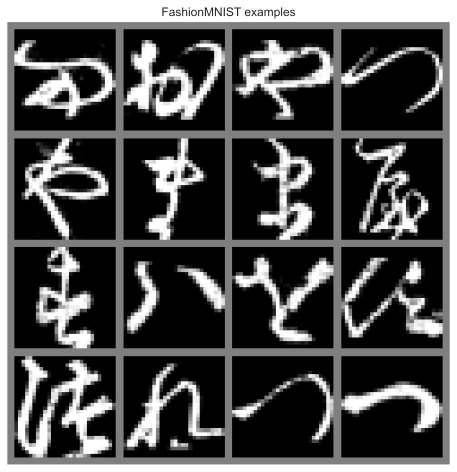

In [7]:
exmp_imgs = [train_set[i][0] for i in range(16)]
img_grid = torchvision.utils.make_grid(
    torch.stack(exmp_imgs, dim=0), nrow=4, normalize=True, pad_value=0.5
)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8, 8))
plt.title("FashionMNIST examples")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()


In [8]:
img, lbl = next(iter(train_set))
img.shape, lbl

(torch.Size([1, 28, 28]), 6)

## Defining Models

### Artificial Neural Network Model

In [9]:
class ANN(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_units):
        super().__init__()

        layers = [nn.Linear(in_shape, hidden_units[0]), nn.ReLU()]
        for i in range(len(hidden_units)-1):
            layers += [nn.Linear(hidden_units[i], hidden_units[i+1]), nn.ReLU()]
        layers += [nn.Linear(hidden_units[-1], out_shape)]
        self.layers = nn.Sequential(*layers)
        self.config = {"in_shape": in_shape, "out_shape": out_shape, "hidden_units": hidden_units}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

In [10]:
ann = ANN(784, 10, [64, 64, 32, 16])

### Convolutional Neural Network Model

In [11]:
class CNN(nn.Module):
    def __init__(self, out_shape, hidden_units):
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc = ANN(64 * 5 * 5, out_shape, hidden_units)
        self.config = {"out_shape": out_shape, "hidden_units": hidden_units}

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [12]:
cnn = CNN(10, [64, 32, 16])

In [13]:
for img, lbl in train_loader:
    cnn(img)
    ann(img)
    break

## Training Model

In [14]:
def train_step(model, loss_module, optimizer, train_loader=train_loader):
    true_preds, loss_tracker = 0.0, 0.0
    model = model.to(device)
    model.train()
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)
        # update parameters
        optimizer.zero_grad()
        preds = model(X)
        loss = loss_module(preds, y)
        loss.backward()
        optimizer.step()
        # track performance
        true_preds += (preds.argmax(dim=-1) == y).sum()
        loss_tracker += loss
    train_loss = loss_tracker / len(train_loader)
    train_acc = true_preds / len(train_set)
    return train_acc.item(), train_loss.item()

In [15]:
def val_step(model, loss_module, val_loader=val_loader):
    true_preds, loss_tracker = 0.0, 0.0
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X = X.to(device)
            y = y.to(device)
            # make predictions
            preds = model(X)
            loss = loss_module(preds, y)
            # track performance
            true_preds += (preds.argmax(dim=-1) == y).sum()
            loss_tracker += loss
    val_loss = loss_tracker / len(val_loader)
    val_acc = true_preds / len(val_set)
    return val_acc.item(), val_loss.item()

In [16]:
def load_model(model_path, model_name, Network):
    import json
    config_file, model_file = _config_file(model_path, model_name), _model_file(model_path, model_name)
    if not os.path.isfile(config_file) or not os.path.isfile(model_file):
        raise Exception(f"Could not find the config file: {config_file} or model file: {model_file}.")
    with open(config_file) as f:
        config_dict = json.load(f)
    model = Network(**config_dict)
    model.load_state_dict(torch.load(model_file))
    return model

def save_model(model, model_path, model_name):
    import json
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _config_file(model_path, model_name), _model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(model.config, f)
    torch.save(model.state_dict(), model_file)

In [17]:
def train(model, model_name, train_loader, val_loader, epochs = 30, patience = 7, overwrite = False):
    optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
    loss_module = nn.CrossEntropyLoss()
    train_acc_tracker, train_loss_tracker = [], []
    val_acc_tracker, val_loss_tracker = [], []
    best_val_epoch = -1

    file_exists = os.path.isfile(_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file {model_name} already exists. Skip training.")
        model = load_model(CHECKPOINT_PATH, model_name, model.__class__)
        return model

    for epoch in range(1, 1+epochs):
        train_acc, train_loss = train_step(model, loss_module, optimizer, train_loader)
        val_acc, val_loss = val_step(model, loss_module, val_loader)
        
        print(f"[{epoch}/{epochs}]", end=" ")
        print(f"train_acc: {train_acc:.4f}; train_loss: {train_loss:.4f};", end=" ")
        print(f"val_acc: {val_acc:.4f}; val_loss: {val_loss:.4f};")

        train_acc_tracker.append(train_acc)
        train_loss_tracker.append(train_loss)
        val_acc_tracker.append(val_acc)
        val_loss_tracker.append(val_loss)

        if len(val_acc_tracker) <= 1 or val_acc > val_acc_tracker[best_val_epoch]:
            model.config["train_acc"] = train_acc_tracker
            model.config["train_loss"] = train_loss_tracker
            model.config["val_acc"] = val_acc_tracker
            model.config["val_loss"] = val_loss_tracker
            best_val_epoch = epoch
            save_model(model, CHECKPOINT_PATH, model_name)
        elif best_val_epoch <= epoch - patience:
            print(f"Early stopping at {epoch} epochs")
            break

    return model

In [18]:
ann = train(ann, "KMNIST_ANN", train_loader, val_loader, epochs=25, overwrite=True)

[1/25] train_acc: 0.0998; train_loss: 2.3052; val_acc: 0.1009; val_loss: 2.2975;
[2/25] train_acc: 0.1645; train_loss: 2.2822; val_acc: 0.2952; val_loss: 2.2585;
[3/25] train_acc: 0.3054; train_loss: 2.1701; val_acc: 0.3147; val_loss: 1.9858;
[4/25] train_acc: 0.4199; train_loss: 1.6592; val_acc: 0.5412; val_loss: 1.3518;
[5/25] train_acc: 0.6188; train_loss: 1.1423; val_acc: 0.6709; val_loss: 1.0083;
[6/25] train_acc: 0.7137; train_loss: 0.8902; val_acc: 0.7449; val_loss: 0.8063;
[7/25] train_acc: 0.7660; train_loss: 0.7423; val_acc: 0.7803; val_loss: 0.7011;
[8/25] train_acc: 0.7891; train_loss: 0.6700; val_acc: 0.8024; val_loss: 0.6394;
[9/25] train_acc: 0.8121; train_loss: 0.5990; val_acc: 0.8219; val_loss: 0.5726;
[10/25] train_acc: 0.8340; train_loss: 0.5371; val_acc: 0.8348; val_loss: 0.5283;
[11/25] train_acc: 0.8507; train_loss: 0.4854; val_acc: 0.8516; val_loss: 0.4843;
[12/25] train_acc: 0.8691; train_loss: 0.4357; val_acc: 0.8648; val_loss: 0.4408;
[13/25] train_acc: 0.8823

In [19]:
cnn = train(cnn, "KMNIST_CNN", train_loader, val_loader, epochs=25, overwrite=True)

[1/25] train_acc: 0.0991; train_loss: 2.3107; val_acc: 0.1046; val_loss: 2.3024;
[2/25] train_acc: 0.0991; train_loss: 2.2991; val_acc: 0.1047; val_loss: 2.2929;
[3/25] train_acc: 0.1605; train_loss: 2.2828; val_acc: 0.1932; val_loss: 2.2634;
[4/25] train_acc: 0.2383; train_loss: 2.1984; val_acc: 0.2990; val_loss: 2.0569;
[5/25] train_acc: 0.4171; train_loss: 1.7001; val_acc: 0.5647; val_loss: 1.3492;
[6/25] train_acc: 0.6211; train_loss: 1.1631; val_acc: 0.6747; val_loss: 0.9791;
[7/25] train_acc: 0.7100; train_loss: 0.8916; val_acc: 0.7339; val_loss: 0.8166;
[8/25] train_acc: 0.7636; train_loss: 0.7411; val_acc: 0.7883; val_loss: 0.6733;
[9/25] train_acc: 0.7969; train_loss: 0.6418; val_acc: 0.7922; val_loss: 0.6416;
[10/25] train_acc: 0.8225; train_loss: 0.5629; val_acc: 0.8308; val_loss: 0.5412;
[11/25] train_acc: 0.8455; train_loss: 0.4942; val_acc: 0.8507; val_loss: 0.4677;
[12/25] train_acc: 0.8611; train_loss: 0.4482; val_acc: 0.8669; val_loss: 0.4271;
[13/25] train_acc: 0.8718

## Plot Training Process

In [20]:
def plot_training(model, metric, model_name = "Neural Network Model"):
    if metric not in ["acc", "loss"]:
        raise Exception("`metric` must be either 'acc' or 'loss'")
    metric_name = "Accuracy" if metric == "acc" else "Loss"
    train_scores = model.config[f"train_{metric}"]
    val_scores = model.config[f"val_{metric}"]

    # Plot the data
    plt.figure(figsize=(5, 3))  # width: 10 inches, height: 6 inches
    plt.plot([i for i in range(1, len(train_scores) + 1)], train_scores, color="blue", label="Train")
    plt.plot([i for i in range(1, len(val_scores) + 1)], val_scores, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.title(f"Training and Validation {metric_name} of {model_name}")
    plt.legend() 
    plt.show()
    plt.close()

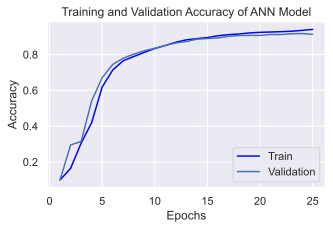

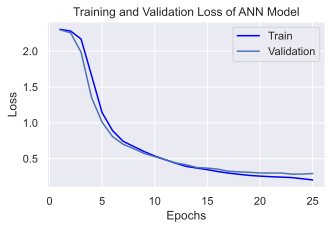

In [21]:
plot_training(ann, "acc", "ANN Model")
plot_training(ann, "loss", "ANN Model")

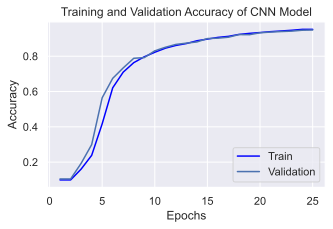

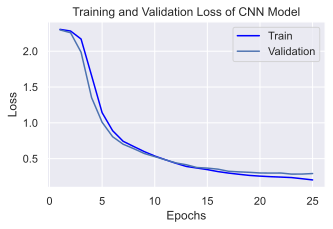

In [22]:
plot_training(cnn, "acc", "CNN Model")
plot_training(ann, "loss", "CNN Model")

## Test Model Performance

In [23]:
def test_model(model, test_loader, loss_module=None):
    if loss_module is None:
        loss_module = nn.CrossEntropyLoss()
    true_preds, loss_tracker = 0.0, 0.0
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            # make predictions
            preds = model(X)
            loss = loss_module(preds, y)
            # track performance
            true_preds += (preds.argmax(dim=-1) == y).sum()
            loss_tracker += loss
    test_loss = loss_tracker / len(test_loader)
    test_acc = true_preds / len(test_set)
    return test_acc.item(), test_loss.item()

In [24]:
acc, loss = test_model(ann, test_loader)
print(f"The ANN model achieved an accuracy of {100*acc:.2f}% with a corresponding loss of {loss:.4f}")

The ANN model achieved an accuracy of 81.53% with a corresponding loss of 0.6720


In [25]:
acc, loss = test_model(cnn, test_loader)
print(f"The CNN model achieved an accuracy of {100*acc:.2f}% with a corresponding loss of {loss:.4f}")

The CNN model achieved an accuracy of 87.80% with a corresponding loss of 0.4131
